In [1]:
import os
import cv2
import numpy as np
import pandas as pd
from keras import layers
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D,Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model, load_model
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import img_to_array, load_img

2024-04-04 19:39:53.943090: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-04 19:39:53.943179: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-04 19:39:54.037173: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-04 19:39:54.260737: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-04 19:39:56.267722: W tensorflow/compiler/tf2

In [2]:
def print_number_of_images_per_class(root_directory):
    for class_folder in os.listdir(root_directory):
        class_folder_path = os.path.join(root_directory, class_folder)
        if os.path.isdir(class_folder_path):
            num_images = len([file for file in os.listdir(class_folder_path) if file.lower().endswith(('.jpeg', '.jpg', '.png'))])
            print(f"Class '{class_folder}' has {num_images} images.")

# Example usage:
dataset_directory = "dataset"
print_number_of_images_per_class(dataset_directory)

Class 'battery' has 945 images.
Class 'biological' has 985 images.
Class 'brown-glass' has 607 images.
Class 'cardboard' has 891 images.
Class 'clothes' has 5325 images.
Class 'green-glass' has 629 images.
Class 'metal' has 769 images.
Class 'paper' has 1050 images.
Class 'plastic' has 865 images.
Class 'shoes' has 1977 images.
Class 'trash' has 697 images.
Class 'white-glass' has 775 images.


In [5]:
dataset="dataset"
img_height,img_width=224,224
batch_size=32

classes=os.listdir(dataset)
print(classes)

n=len(classes)

# all the images and their corresponding labels
trash_images=[]
labels=[]

for trash in classes:
    images=os.path.join(dataset,trash)
    for image in os.listdir(images):
        trash_images.append(os.path.join(images,image))
        labels.append(trash)

print(trash_images)
print(labels)

['battery', 'biological', 'brown-glass', 'cardboard', 'clothes', 'green-glass', 'metal', 'paper', 'plastic', 'shoes', 'trash', 'white-glass']
['dataset/battery/battery1.jpg', 'dataset/battery/battery10.jpg', 'dataset/battery/battery100.jpg', 'dataset/battery/battery101.jpg', 'dataset/battery/battery102.jpg', 'dataset/battery/battery103.jpg', 'dataset/battery/battery104.jpg', 'dataset/battery/battery105.jpg', 'dataset/battery/battery106.jpg', 'dataset/battery/battery107.jpg', 'dataset/battery/battery108.jpg', 'dataset/battery/battery109.jpg', 'dataset/battery/battery11.jpg', 'dataset/battery/battery110.jpg', 'dataset/battery/battery111.jpg', 'dataset/battery/battery112.jpg', 'dataset/battery/battery113.jpg', 'dataset/battery/battery114.jpg', 'dataset/battery/battery115.jpg', 'dataset/battery/battery116.jpg', 'dataset/battery/battery117.jpg', 'dataset/battery/battery118.jpg', 'dataset/battery/battery119.jpg', 'dataset/battery/battery12.jpg', 'dataset/battery/battery120.jpg', 'dataset/bat

In [6]:
x_train,x_test,y_train,y_test=train_test_split(trash_images,labels,test_size=0.3,random_state=42)

x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=0.5, random_state=42)

train_data = pd.DataFrame({"trash_images": x_train, "labels": y_train})
val_data = pd.DataFrame({"trash_images": x_val, "labels": y_val})
test_data = pd.DataFrame({"trash_images": x_test, "labels": y_test})


In [7]:
train_aug=ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode="nearest"
)
test_aug=ImageDataGenerator(
    rescale=1./255
)
val_aug=ImageDataGenerator(
    rescale=1./255
)

train_gen=train_aug.flow_from_dataframe(
    train_data,
    x_col="trash_images",
    y_col="labels",
    target_size=(img_height,img_width),
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=True
)

test_gen=test_aug.flow_from_dataframe(
    test_data,
    x_col="trash_images",
    y_col="labels",
    target_size=(img_height,img_width),
    batch_size=batch_size,
    class_mode="categorical"
)

val_gen=val_aug.flow_from_dataframe(
    val_data,
    x_col="trash_images",
    y_col="labels",
    target_size=(img_height,img_width),
    batch_size=batch_size,
    class_mode="categorical"
)

Found 10860 validated image filenames belonging to 12 classes.
Found 2327 validated image filenames belonging to 12 classes.
Found 2328 validated image filenames belonging to 12 classes.


In [8]:
feature_ext_model= "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_s/feature_vector/2"

pretrained_mod =hub.KerasLayer(
    feature_ext_model, input_shape=(img_height, img_width, 3), trainable=False
)

model=tf.keras.Sequential([
    pretrained_mod,
    Dropout(0.3),
    Dense(n,activation="softmax")
])

model.compile(optimizer="adam",loss="categorical_crossentropy",metrics=["accuracy"])
model.summary()

2024-04-04 19:47:31.269633: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-04 19:47:31.560134: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-04 19:47:31.560210: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-04 19:47:31.563567: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-04 19:47:31.563659: I external/local_xla/xla/stream_executor

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              20331360  
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 12)                15372     
                                                                 
Total params: 20346732 (77.62 MB)
Trainable params: 15372 (60.05 KB)
Non-trainable params: 20331360 (77.56 MB)
_________________________________________________________________


In [10]:
history=model.fit(
    train_gen,
    epochs=5,
    validation_data=val_gen,
)
model.save("model.h5")

Epoch 1/5
340/340 [==============================] - 253s 744ms/step - loss: 0.2755 - accuracy: 0.9206 - val_loss: 0.1724 - val_accuracy: 0.9532
Epoch 2/5
340/340 [==============================] - 190s 558ms/step - loss: 0.1994 - accuracy: 0.9400 - val_loss: 0.1469 - val_accuracy: 0.9609
Epoch 3/5
340/340 [==============================] - 186s 546ms/step - loss: 0.1642 - accuracy: 0.9493 - val_loss: 0.1387 - val_accuracy: 0.9605
Epoch 4/5
340/340 [==============================] - 175s 514ms/step - loss: 0.1621 - accuracy: 0.9523 - val_loss: 0.1373 - val_accuracy: 0.9618
Epoch 5/5
340/340 [==============================] - 187s 550ms/step - loss: 0.1406 - accuracy: 0.9569 - val_loss: 0.1298 - val_accuracy: 0.9665


/home/satya/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


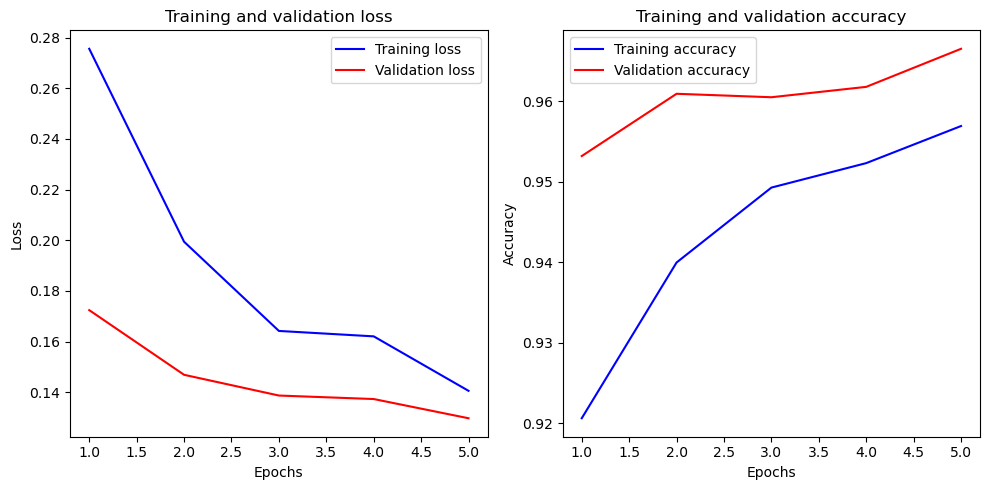

In [11]:
import matplotlib.pyplot as plt


train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1, len(train_loss) + 1)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [12]:
modelTry=model
test_loss, test_accuracy = modelTry.evaluate(test_gen)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

73/73 [==============================] - 38s 518ms/step - loss: 0.1212 - accuracy: 0.9661
Test Loss: 0.12116871029138565
Test Accuracy: 0.9660506844520569


In [13]:
label_ind={}
for i in range(n):
    label_ind[i]=classes[i]

In [17]:
from tensorflow.keras.preprocessing import image

def preprocess_image(image_path):
    img = image.load_img(image_path, target_size=(img_height,img_width))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) 
    img_array = img_array / 255.0 
    return img_array

def predict_on_custom_image(image_path):
    img_array = preprocess_image(image_path)
    predictions = modelTry.predict(img_array)
    predList=predictions.tolist()
    # print(predList)
    l=[]
    for i in range(n):
        temp=[predList[0][i],label_ind[i]]
        l.append(temp)
    l.sort()
    l.reverse()
    ans=[]
    for i in range(5):
        ans.append(l[i])
    predicted_class = np.argmax(predictions, axis=1)
    return ans[0]

In [18]:
custom_image_path = "custom_testing/food.jpg"
predicted_classes = predict_on_custom_image(custom_image_path)
for x in predicted_classes:
    print(x)

1/1 [==============================] - 0s 274ms/step
0.3120977282524109
biological
